In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import nbodykit.lab as nb

import mpl_scatter_density
# Make the norm object to define the image stretch
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize

# Matplotlib darkmode + color picker 
plt.style.use('light_mode')

import yaml
import io



In [2]:
# Read YAML file
with open("../config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)
    
config

{'run_name': 'density_cube_snap_099_full_1024_all_species',
 'input_directory': '/global/cscratch1/sd/james12/Illustris_TNG_Data/TNG_Density_Cubes/simple_density_cubes/',
 'snapfile_root': 99,
 'num_snaps': 1,
 'output_directory': '/global/cscratch1/sd/james12/NEXUS_analysis/',
 'xmin': 0.0,
 'xmax': 205000.0,
 'num_scales': 10,
 'nx': 1024,
 'DM_particle_mass_TNG': 0.00398342749867548,
 'GAS_particle_mass_TNG': 0.000743736,
 'DM_particle_mass_Dark': 0.0047271638660809,
 'N_DM': 15625000000,
 'N_GAS': 15625000000,
 'algorithm': 'NEXUS+',
 'simulation_type': 'All'}

# Pie Charts

In [3]:
def calc_volume_percentages(sim_type):
    """
    Function to compute the volume fractions of structures in a simulation.
    """
    if sim_type == "Dark":
        # mass_of_average_cell = config["DM_particle_mass_Dark"] * config["N_DM"] / (config["nx"]**3)
        # total_mass = config["DM_particle_mass_Dark"] * config["N_DM"] 
        total_volume = config["xmax"] ** 3
        volume_per_cell = total_volume / (config["nx"]**3)
        N_cells = (config["nx"]**3)

        clusbool = np.load("/global/cscratch1/sd/james12/NEXUS_analysis/DM_only_1024_snap_099/all_halos/density_cube_snap_099_full_1024_dm_cluster_bool_filter.npy")
        filbool = np.load("/global/cscratch1/sd/james12/NEXUS_analysis/DM_only_1024_snap_099/all_halos/density_cube_snap_099_full_1024_dm_filament_bool_filter.npy")
        wallbool = np.load("/global/cscratch1/sd/james12/NEXUS_analysis/DM_only_1024_snap_099/all_halos/density_cube_snap_099_full_1024_dm_wall_bool_filter.npy")

        num_clus_cells = len(clusbool[np.where (clusbool==1)])
        num_wall_cells = len(wallbool[np.where (wallbool==1)])
        num_fil_cells = len(filbool[np.where (filbool==1)])

        volume_frac_clus = (num_clus_cells/N_cells * total_volume) / total_volume
        volume_frac_wall = (num_wall_cells/N_cells * total_volume) / total_volume
        volume_frac_fil = (num_fil_cells/N_cells * total_volume) / total_volume
        volume_frac_voids = 1 - (volume_frac_clus + volume_frac_wall + volume_frac_fil)
        
    elif sim_type=="Full":
        # mass_of_average_cell = config["DM_particle_mass_Dark"] * config["N_DM"] / (config["nx"]**3)
        # total_mass = config["DM_particle_mass_Dark"] * config["N_DM"] 
        total_volume = config["xmax"] ** 3
        volume_per_cell = total_volume / (config["nx"]**3)
        N_cells = (config["nx"]**3)
        
        clusbool = np.load("/global/cscratch1/sd/james12/NEXUS_analysis/Full_Species_1024_snap_099/all_halos/density_cube_snap_099_full_1024_all_species_cluster_bool_filter.npy")
        filbool = np.load("/global/cscratch1/sd/james12/NEXUS_analysis/Full_Species_1024_snap_099/all_halos/density_cube_snap_099_full_1024_all_species_filament_bool_filter.npy")
        wallbool = np.load("/global/cscratch1/sd/james12/NEXUS_analysis/Full_Species_1024_snap_099/all_halos/density_cube_snap_099_full_1024_all_species_wall_bool_filter.npy")

        num_clus_cells = len(clusbool[np.where (clusbool==1)])
        num_wall_cells = len(wallbool[np.where (wallbool==1)])
        num_fil_cells = len(filbool[np.where (filbool==1)])

        volume_frac_clus = (num_clus_cells/N_cells * total_volume) / total_volume
        volume_frac_wall = (num_wall_cells/N_cells * total_volume) / total_volume
        volume_frac_fil = (num_fil_cells/N_cells * total_volume) / total_volume
        volume_frac_voids = 1 - (volume_frac_clus + volume_frac_wall + volume_frac_fil)
    else:
        raise AssertionError("Incorrect Sim Type: Enter ('Dark' or 'Full')")
        
    
    return [volume_frac_clus, volume_frac_fil, volume_frac_wall, volume_frac_voids]

In [4]:
def calc_mass_percentages(sim_type):
    """
    Function to compute the mass fractions of structures in a simulation.
    """
    if sim_type == "Dark":

        total_volume = config["xmax"] ** 3
        volume_per_cell = total_volume / (config["nx"]**3)
        N_cells = (config["nx"]**3)
        
        density_cube = np.load(config["input_directory"] +"density_cube_snap_099_full_1024_dm" + ".npy")

        clusbool = np.load("/global/cscratch1/sd/james12/NEXUS_analysis/DM_only_1024_snap_099/all_halos/density_cube_snap_099_full_1024_dm_cluster_bool_filter.npy")
        filbool = np.load("/global/cscratch1/sd/james12/NEXUS_analysis/DM_only_1024_snap_099/all_halos/density_cube_snap_099_full_1024_dm_filament_bool_filter.npy")
        wallbool = np.load("/global/cscratch1/sd/james12/NEXUS_analysis/DM_only_1024_snap_099/all_halos/density_cube_snap_099_full_1024_dm_wall_bool_filter.npy")
        
        #pull out density
        filtered_clus = density_cube
        filtered_clus = filtered_clus * clusbool.astype(int) 
        sum_clus = np.sum(filtered_clus * volume_per_cell)
        del clusbool 
        del filtered_clus

        filtered_fil = density_cube
        filtered_fil = filtered_fil * filbool.astype(int)
        sum_fil = np.sum(filtered_fil * volume_per_cell)
        del filbool
        del filtered_fil
    
        filtered_wall = density_cube
        filtered_wall = filtered_wall * wallbool.astype(int)
        sum_wall = np.sum(filtered_wall * volume_per_cell)
        del wallbool
        del filtered_wall
        
        sum_total = np.sum(density_cube * volume_per_cell)

        mass_frac_clus = sum_clus/sum_total
        mass_frac_wall = sum_wall/sum_total
        mass_frac_fil = sum_fil/sum_total
        mass_frac_voids = 1 - (mass_frac_clus + mass_frac_wall + mass_frac_fil)
        
    elif sim_type=="Full":
   
        total_volume = config["xmax"] ** 3
        volume_per_cell = total_volume / (config["nx"]**3)
        N_cells = (config["nx"]**3)
        
        density_cube = np.load(config["input_directory"] +"density_cube_snap_099_full_1024_all_species" + ".npy")
        
        clusbool = np.load("/global/cscratch1/sd/james12/NEXUS_analysis/Full_Species_1024_snap_099/all_halos/density_cube_snap_099_full_1024_all_species_cluster_bool_filter.npy")
        filbool = np.load("/global/cscratch1/sd/james12/NEXUS_analysis/Full_Species_1024_snap_099/all_halos/density_cube_snap_099_full_1024_all_species_filament_bool_filter.npy")
        wallbool = np.load("/global/cscratch1/sd/james12/NEXUS_analysis/Full_Species_1024_snap_099/all_halos/density_cube_snap_099_full_1024_all_species_wall_bool_filter.npy")

        #pull out density
        filtered_clus = density_cube
        filtered_clus = filtered_clus * clusbool.astype(int) 
        sum_clus = np.sum(filtered_clus * volume_per_cell)
        del clusbool 
        del filtered_clus

        filtered_fil = density_cube
        filtered_fil = filtered_fil * filbool.astype(int)
        sum_fil = np.sum(filtered_fil * volume_per_cell)
        del filbool
        del filtered_fil
    
        filtered_wall = density_cube
        filtered_wall = filtered_wall * wallbool.astype(int)
        sum_wall = np.sum(filtered_wall * volume_per_cell)
        del wallbool
        del filtered_wall
        
        sum_total = np.sum(density_cube * volume_per_cell)

        mass_frac_clus = sum_clus/sum_total
        mass_frac_wall = sum_wall/sum_total
        mass_frac_fil = sum_fil/sum_total
        mass_frac_voids = 1 - (mass_frac_clus + mass_frac_wall + mass_frac_fil)
    else:
        raise AssertionError("Incorrect Sim Type: Enter ('Dark' or 'Full')")
        
    
    return [mass_frac_clus, mass_frac_fil, mass_frac_wall, mass_frac_voids]

In [5]:
dm_only_percentages = calc_volume_percentages("Dark")
full_percentages = calc_volume_percentages("Full")

In [6]:
dm_only_percentages_mass = calc_mass_percentages("Dark")
full_percentages_mass = calc_mass_percentages("Full")

In [7]:
print("Mass Fractions \n")

print("Full Matter \n")
print("The mass percentage of Clusters is {0:0.02f}%".format(full_percentages_mass[0]*100))
print("The mass percentage of Filaments is {0:0.02f}%".format(full_percentages_mass[1]*100))
print("The mass percentage of Walls is {0:0.02f}%".format(full_percentages_mass[2]*100))
print("The mass percentage of Voids is {0:0.02f}%".format(full_percentages_mass[3]*100))

print('\n')
print("Dark Matter Only \n")

print("The mass percentage of Clusters is {0:0.02f}%".format(dm_only_percentages_mass[0]*100))
print("The mass percentage of Filaments is {0:0.02f}%".format(dm_only_percentages_mass[1]*100))
print("The mass percentage of Walls is {0:0.02f}%".format(dm_only_percentages_mass[2]*100))
print("The mass percentage of Voids is {0:0.02f}%".format(dm_only_percentages_mass[3]*100))

Mass Fractions 

Full Matter 

The mass percentage of Clusters is 39.14%
The mass percentage of Filaments is 41.45%
The mass percentage of Walls is 11.84%
The mass percentage of Voids is 7.57%


Dark Matter Only 

The mass percentage of Clusters is 45.20%
The mass percentage of Filaments is 36.34%
The mass percentage of Walls is 11.55%
The mass percentage of Voids is 6.91%


In [8]:
print("Volume Fractions \n")

print("Full Matter \n")
print("The volume percentage of Clusters is {0:0.05f}%".format(full_percentages[0]*100))
print("The volume percentage of Filaments is {0:0.02f}%".format(full_percentages[1]*100))
print("The volume percentage of Walls is {0:0.02f}%".format(full_percentages[2]*100))
print("The volume percentage of Voids is {0:0.02f}%".format(full_percentages[3]*100))

print('\n')
print("Dark Matter Only \n")

print("The volume percentage of Clusters is {0:0.05f}%".format(dm_only_percentages[0]*100))
print("The volume percentage of Filaments is {0:0.02f}%".format(dm_only_percentages[1]*100))
print("The volume percentage of Walls is {0:0.02f}%".format(dm_only_percentages[2]*100))
print("The volume percentage of Voids is {0:0.02f}%".format(dm_only_percentages[3]*100))

Volume Fractions 

Full Matter 

The volume percentage of Clusters is 0.42272%
The volume percentage of Filaments is 16.42%
The volume percentage of Walls is 21.46%
The volume percentage of Voids is 61.70%


Dark Matter Only 

The volume percentage of Clusters is 0.47364%
The volume percentage of Filaments is 15.77%
The volume percentage of Walls is 22.36%
The volume percentage of Voids is 61.40%


In [3]:
#quoting the printed results above

#mass fractions
full_percentages_mass = [0.3914, 0.4145, 0.1184, 0.0757]
dm_only_percentages_mass = [0.4520, 0.3634, 0.1155, 0.0691]

#volume fractions
full_percentages = [0.0042272, 0.1642, 0.2146, 0.6170]
dm_only_percentages = [0.0047364, 0.1577, 0.2236, 0.6140]

In [24]:

def plot_pie(DM_percents, FULL_percents, type_flag):
    fig, ax = plt.subplots(1,2, figsize=(18, 6), subplot_kw=dict(aspect="equal"))

    outer_colors = ['orangered', 'dodgerblue', 'darkgreen', 'indigo']
    # DM_percents = dm_only_percentages
    # FULL_percents = full_percentages
    labels = ["Clusters","Filaments", "Walls", "Voids"]
    if type_flag == 'volume':
        fig.suptitle("Volume Fractions", fontsize=40)
    elif type_flag == 'mass':
        fig.suptitle("Mass Fractions", fontsize=40)
    ##########################
    #      Top Left
    ##########################
    wedges, texts = ax[0].pie(FULL_percents,startangle=-40,wedgeprops=dict(width=0.5, edgecolor='k'),
                              colors=outer_colors, textprops=dict(color='k', fontsize=16))

    bbox_props = dict(boxstyle="square,pad=0.2", fc="w", ec="w", lw=0.7)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        if i == 0:
            ax[0].annotate("{0:0.1f}%".format(FULL_percents[i]* 100), xy=(x, y), xytext=(1.2*np.sign(x), 1.2*y),
                        horizontalalignment=horizontalalignment, **kw)
        elif i == 1:
            ax[0].annotate("{0:0.1f}%".format(FULL_percents[i]* 100), xy=(x, y), xytext=(1.2*np.sign(x), 1.2*y),
                        horizontalalignment=horizontalalignment, **kw)
        elif i == 2:
            ax[0].annotate("{0:0.1f}%".format(FULL_percents[i]* 100), xy=(x, y), xytext=(1.2*np.sign(x), 1.2*y),
                        horizontalalignment=horizontalalignment, **kw)

        else:
            ax[0].annotate("{0:0.1f}%".format(FULL_percents[i]* 100), xy=(x, y), xytext=(1.2*np.sign(x), 1.2*y),
                        horizontalalignment=horizontalalignment, **kw)


    ax[0].text(-0.28,-0.05, "Hydro", fontsize=28)


    ###########################
    #      Top Right
    ###########################
    wedges, texts = ax[1].pie(DM_percents,startangle=-40,wedgeprops=dict(width=0.5, edgecolor='k'), colors=outer_colors, textprops=dict(color='k', fontsize=16))

    bbox_props = dict(boxstyle="square,pad=0.2", fc="w", ec="w", lw=0.7)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        if i == 0:
            ax[1].annotate("{0:0.1f}%".format(DM_percents[i]* 100), xy=(x, y), xytext=(1.2*np.sign(x), 1.2*y),
                        horizontalalignment=horizontalalignment, **kw)
        elif i == 1:
            ax[1].annotate("{0:0.1f}%".format(DM_percents[i]* 100), xy=(x, y), xytext=(1.2*np.sign(x), 1.2*y),
                        horizontalalignment=horizontalalignment, **kw)
        elif i == 2:
            ax[1].annotate("{0:0.1f}%".format(DM_percents[i] * 100), xy=(x, y), xytext=(1.2*np.sign(x), 1.2*y),
                        horizontalalignment=horizontalalignment, **kw)

        else:
            ax[1].annotate("{0:0.1f}%".format(DM_percents[i]* 100), xy=(x, y), xytext=(1.2*np.sign(x), 1.2*y),
                        horizontalalignment=horizontalalignment, **kw)


    ax[1].text(-0.425,-0.05, "DM-Only", fontsize=28)

    ax[1].legend(wedges, labels , frameon=False, bbox_to_anchor=(1.6, 0.4, 0.5, 0.5))

    fig.tight_layout()
    # fig.savefig("mass_pie_chart.pdf", dpi=300, bbox_inches="tight")
    plt.show()

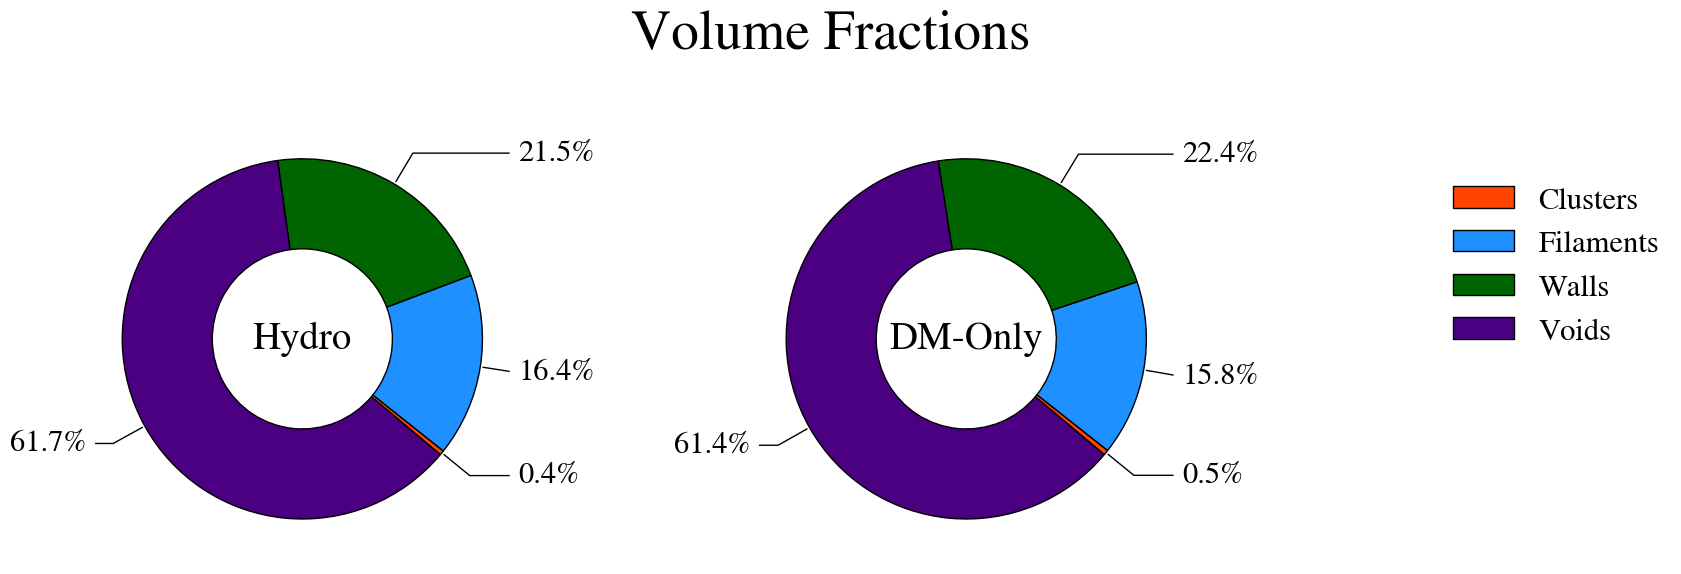

In [21]:
plot_pie(dm_only_percentages, full_percentages, 'volume')

/global/homes/j/james12/.conda/envs/baryon_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  app.launch_new_instance()


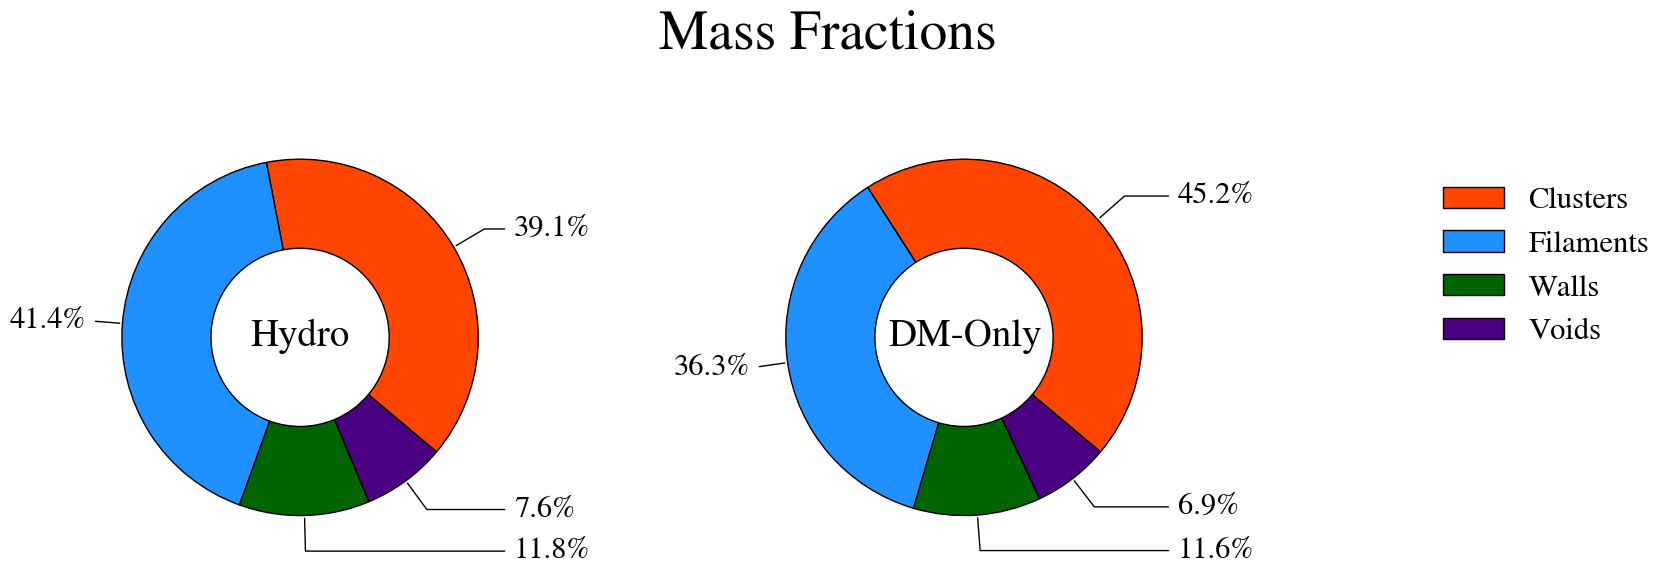

In [25]:
plot_pie(dm_only_percentages_mass, full_percentages_mass, 'mass')